# Parallel computations: dask

In [1]:
import pandas as pd
import numpy as np

import glob

allfiles_trade=glob.glob(r"C:\Projects\FIN-525\data\extraction\TRTH\raw\equities\US\trade\AAPL.OQ\*")
allfiles_bbo=glob.glob(r"C:\Projects\FIN-525\data\extraction\TRTH\raw\equities\US\bbo\AAPL.OQ\*")

In [2]:
allfiles_trade=np.sort(allfiles_trade)[:100]
allfiles_bbo=np.sort(allfiles_bbo[:100])

In [3]:
allfiles_trade

array(['C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-01-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-04-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-05-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-06-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-07-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-08-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-11-AAPL.OQ-trade.csv.gz',
       'C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-01-12-AAPL.OQ-trade.csv.gz',
       '

In [7]:
pd.read_csv('C:\\Projects\\FIN-525\\data\\extraction\\TRTH\\raw\\equities\\US\\trade\\AAPL.OQ\\2010-05-20-AAPL.OQ-trade.csv.gz')

,xltime,trade-price,trade-volume,trade-stringflag,trade-rawflag
0,40318.468249,246.41,100,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
1,40318.468249,246.41,100,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
2,40318.469493,246.41,100,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
3,40318.469493,246.41,100,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
4,40318.471150,246.45,200,marketclosed|volumeupdate,[GV4_TEXT ]@FT ...
...,...,...,...,...,...
111170,40318.999029,235.00,100,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
111171,40318.999092,235.00,180,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...
111172,40318.999591,235.16,129,marketclosed|volumeupdate,[GV4_TEXT ]@FT ...
111173,40318.999721,235.25,250,marketclosed|volumeupdate,[GV4_TEXT ]@ T ...


### Dask in practice

In [4]:
import dask
dask.config.set(scheduler="processes")

@dask.delayed
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
   
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF


@dask.delayed
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
        
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [27]:
allpromises_trade=[load_TRTH_trade(fn) for fn in allfiles_trade]    # this takes not time at all
allpromises_bbo=[load_TRTH_bbo(fn) for fn in allfiles_bbo]

In [28]:
alltrades=dask.compute(allpromises_trade)[0]                 # now the computations take place. Monitor your CPU !
allbbos=dask.compute(allpromises_bbo)[0]                 # now the computations take place. Monitor your CPU !

In [29]:
alltrades=pd.concat(alltrades)
allbbos=pd.concat(allbbos)

In [30]:
allevents=alltrades.join(allbbos,how='inner')

In [31]:
allevents.ffill(inplace=True)
allevents

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,,,
2010-01-04 09:30:00.615974400-05:00,213.5375,1130.0,213.46,1,213.53,1
2010-01-04 09:30:00.615974400-05:00,213.5375,1130.0,213.40,1,213.53,1
2010-01-04 09:30:00.636019200-05:00,213.5000,100.0,213.44,1,213.55,4
2010-01-04 09:30:00.636019200-05:00,213.5000,100.0,213.46,1,213.55,4
2010-01-04 09:30:00.648979199-05:00,213.5500,100.0,213.47,1,213.55,3
...,...,...,...,...,...,...
2010-05-20 15:59:59.813001600-04:00,237.5650,800.0,237.18,38,237.57,56
2010-05-20 15:59:59.813001600-04:00,237.5650,800.0,237.18,37,237.57,56
2010-05-20 15:59:59.813001600-04:00,237.5650,800.0,237.18,37,237.57,52


In [40]:
import time

t0=time.time()
allevents.to_csv('allevents.csv.gz')
t1=time.time()
t1-t0

159.2879991531372

In [45]:
allevents.index

DatetimeIndex(['2010-01-04 09:30:00.615974400-05:00',
               '2010-01-04 09:30:00.615974400-05:00',
               '2010-01-04 09:30:00.636019200-05:00',
               '2010-01-04 09:30:00.636019200-05:00',
               '2010-01-04 09:30:00.648979199-05:00',
               '2010-01-04 09:30:00.648979199-05:00',
               '2010-01-04 09:30:00.881999999-05:00',
               '2010-01-04 09:30:00.881999999-05:00',
               '2010-01-04 09:30:00.881999999-05:00',
               '2010-01-04 09:30:00.881999999-05:00',
               ...
               '2010-05-20 15:59:59.736969600-04:00',
               '2010-05-20 15:59:59.736969600-04:00',
               '2010-05-20 15:59:59.736969600-04:00',
               '2010-05-20 15:59:59.736969600-04:00',
               '2010-05-20 15:59:59.736969600-04:00',
               '2010-05-20 15:59:59.813001600-04:00',
               '2010-05-20 15:59:59.813001600-04:00',
               '2010-05-20 15:59:59.813001600-04:00',
         

In [51]:
import time
t0=time.time()
allevents.to_parquet("allevents.parquet", allow_truncated_timestamps=True, coerce_timestamps='ms')
t1=time.time()
t1-t0

1.0939984321594238

In [52]:
import pyarrow as pa   # penalty to convert the DataFrame to arrow RAM representation 
t0=time.time()
pa.Table.from_pandas(allevents)
t1=time.time()
t1-t0

0.04748964309692383

In [55]:
alltrades["5min"]=(alltrades.index.hour*60+alltrades.index.minute)//5
numtrades_5min=alltrades["5min"].value_counts()

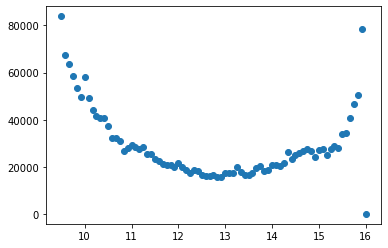

In [67]:
import matplotlib.pyplot as plt
plt.scatter(numtrades_5min.index*5/60,numtrades_5min.values)

In [74]:
allevents["s"]=2*((allevents["ask-price"]-allevents["trade_price"])>(allevents["trade_price"]-allevents["bid-price"]))-1

In [84]:
# s is too long for the usual auto-correlation functions (complexity O(N^2)). 
# One should use Fast Fourier Transforms instead
# source: https://dsp.stackexchange.com/questions/54924/autocorrelation-numpy-versus-fft
# exercise: show that the auto-correlation can be obtained from the power spectrum

s = allevents["s"].values
s = np.concatenate((s,np.zeros(len(s)-1))) # added zeros to your signal
A = np.fft.fft(s)
S = np.conj(A)*A
c_fourier = np.fft.ifft(S)
c_fast = c_fourier[:(c_fourier.size//2)+1]/len(s)

So I can discard the imaginary parts because they are rementants of numerical error --> they're very small

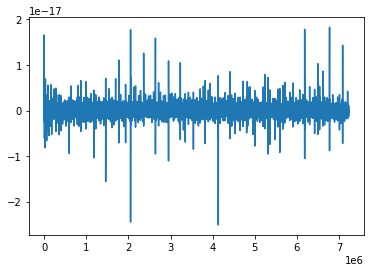

In [98]:
plt.plot(c_fast.imag)

C:\Users\markm\.conda\envs\hft\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


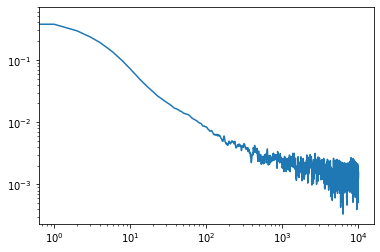

In [59]:
import matplotlib.pyplot as plt
plt.plot(c_fast[:10000,])
plt.xscale("log")
plt.yscale("log")

C:\Users\markm\.conda\envs\hft\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


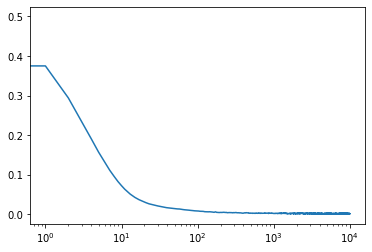

In [73]:
plt.plot(c_fast[:10000,])
plt.xscale("log")

Mike's way

In [88]:
s = allevents["s"].values
s = np.concatenate((s,np.zeros(len(s)-1))) # added zeros to your signal
c = np.fft.fft(np.square(np.fft.ifft(s)))
#A = np.fft.fft(s)
#S = np.conj(A)*A
# c_fourier = np.fft.ifft(S)
# c_fast = c_fourier[:(c_fourier.size//2)+1]/len(s)

C:\Users\markm\.conda\envs\hft\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


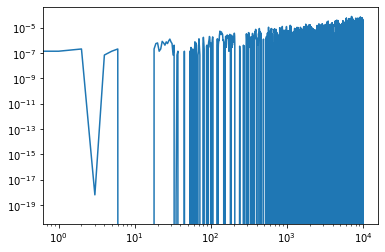

In [93]:
import matplotlib.pyplot as plt
plt.plot(c[:10000,])
plt.xscale("log")
plt.yscale("log")

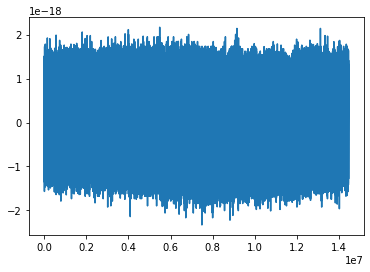

In [100]:
plt.plot(c.imag)

In [92]:
c_fast

array([5.00000035e-01-9.44035775e-20j, 3.74940186e-01+8.17099532e-18j,
       2.94082437e-01+8.98659368e-18j, ...,
       2.07595662e-07+9.21157043e-19j, 1.38397108e-07+3.07856458e-19j,
       6.91985541e-08+2.45189630e-19j])